<a href="https://colab.research.google.com/github/JenBanks8585/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/Jen_Banks2_ensemble__LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
#Imports

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import  SVC

In [3]:
# Reading train and test sets

train_orig = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test_orig = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train_orig.shape, test_orig.shape

((59400, 41), (14358, 40))

In [0]:
train=train_orig.copy()
test=test_orig.copy()

In [5]:
train['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [6]:
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [0]:
# imports

from sklearn.model_selection import train_test_split

#Splitting DF into train and test sets

train, val = train_test_split(train, test_size=0.2)

In [8]:
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [9]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [11]:
# New code for Pandas Profiling version 2.4

from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

#profile

In [0]:
#profile.to_file(output_file="tanzania_profile_report_minimal.html")

In [0]:
# Data Wranggling

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()

    # About 6.1% of 'funder' cell are missing, fill with mode
    X['funder']=X['funder'].fillna(X.funder.mode()[0], inplace=False)

    # About 6.2% of 'installer' cell are missing, fill with mode
    X['installer']=X['installer'].fillna(X['installer'].mode()[0], inplace=False)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # About 5.7% of 'public_meeting' cell are missing, fill with mode
    X['public_meeting']=X['public_meeting'].fillna(X['public_meeting'].mode()[0],
                                                   inplace=False)

    # About 6.5% of 'public_meeting' cell are missing, fill with mode
    X['scheme_management']=X['scheme_management'].fillna(X['scheme_management'].mode()[0],
                                                         inplace=False)
    
    # About 5.2% of 'public_meeting' cell are missing, fill with mode
    X['permit']=X['permit'].fillna(X['permit'].mode()[0], inplace=False)

    # Change 'date_recorded to datetime object
    X['date_recorded']=pd.to_datetime(X['date_recorded'],
                                      infer_datetime_format=False) 

    #Adding a year column to DFs
    X['year'] = pd.DatetimeIndex(X['date_recorded']).year

    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# Checking columns with high cardinality

#A. funder
funder_top50= train['funder'].value_counts()[:50].index
train.loc[~train['funder'].isin(funder_top50), 'funder'] = 'OTHER'
val.loc[~val['funder'].isin(funder_top50), 'funder'] = 'OTHER'
test.loc[~test['funder'].isin(funder_top50), 'funder'] = 'OTHER'

#B. installer
installer_top50= train['installer'].value_counts()[:50].index
train.loc[~train['installer'].isin(installer_top50), 'installer'] = 'OTHER'
val.loc[~val['installer'].isin(installer_top50), 'installer'] = 'OTHER'
test.loc[~test['installer'].isin(installer_top50), 'installer'] = 'OTHER'

#C. wpt_name
wpt_name_top50= train['wpt_name'].value_counts()[:50].index
train.loc[~train['wpt_name'].isin(wpt_name_top50), 'wpt_name'] = 'OTHER'
val.loc[~val['wpt_name'].isin(wpt_name_top50), 'wpt_name'] = 'OTHER'
test.loc[~test['wpt_name'].isin(wpt_name_top50), 'wpt_name'] = 'OTHER'

#D. subvillage
subvillage_top50= train['subvillage'].value_counts()[:50].index
train.loc[~train['subvillage'].isin(subvillage_top50), 'subvillage'] = 'OTHER'
val.loc[~val['subvillage'].isin(subvillage_top50), 'subvillage'] = 'OTHER'
test.loc[~test['subvillage'].isin(subvillage_top50), 'subvillage'] = 'OTHER'

#E. lga
lga_top50= train['lga'].value_counts()[:50].index
train.loc[~train['lga'].isin(lga_top50), 'lga'] = 'OTHER'
val.loc[~val['lga'].isin(lga_top50), 'lga'] = 'OTHER'
test.loc[~test['lga'].isin(lga_top50), 'lga'] = 'OTHER'

#F. ward
ward_top50= train['ward'].value_counts()[:50].index
train.loc[~train['ward'].isin(ward_top50), 'ward'] = 'OTHER'
val.loc[~val['ward'].isin(ward_top50), 'ward'] = 'OTHER'
test.loc[~test['ward'].isin(ward_top50), 'ward'] = 'OTHER'

#G. scheme_name
scheme_name_top50= train['scheme_name'].value_counts()[:50].index
train.loc[~train['scheme_name'].isin(scheme_name_top50), 'scheme_name'] = 'OTHER'
val.loc[~val['scheme_name'].isin(scheme_name_top50), 'scheme_name'] = 'OTHER'
test.loc[~test['scheme_name'].isin(scheme_name_top50), 'scheme_name'] = 'OTHER'

In [12]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
features = train.drop(columns=[
                               target,
                               'id',
                               'scheme_name',
                               'date_recorded']).columns.tolist()


print(features)

['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'year']


In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [17]:
# using DecisionTreeClassifier, min_leaf

pipeline4=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    DecisionTreeClassifier(min_samples_leaf=30 ,random_state=42)
)

pipeline4.fit(X_train, y_train)
print(pipeline4.score(X_train, y_train))
print(pipeline4.score(X_val, y_val))

0.7973484848484849
0.7602693602693603


In [41]:
# using DecisionTreeClassifier, max_depth

pipeline_dt=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    DecisionTreeClassifier(max_depth=20 ,random_state=42)
)

pipeline_dt.fit(X_train, y_train)
print(pipeline_dt.score(X_train, y_train))
print(pipeline_dt.score(X_val, y_val))

0.881986531986532
0.7698653198653199


In [18]:
# Using randomforest classifier

pipeline_rf=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    StandardScaler(),
    RandomForestClassifier(n_estimators=50)
)

pipeline_rf.fit(X_train, y_train)
print(pipeline_rf.score(X_train, y_train))
print(pipeline_rf.score(X_val, y_val))

0.9974957912457912
0.797979797979798


In [0]:
# Creating a prediction file

y_pred_rf=pipeline_rf.predict(X_test)
submission_rf=sample_submission.copy()
submission_rf['status_group']=y_pred_rf
submission_rf.to_csv('submission__rf.csv', index=False)

In [20]:
# Using Bagging ensemble, no replacement, 20 bags

pipeline_bag4=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    BaggingClassifier(DecisionTreeClassifier(),
                      n_estimators=20,
                      max_features=0.6,
                      max_samples=0.4,
                      bootstrap=False,
                      bootstrap_features= False)
)

pipeline_bag4.fit(X_train, y_train)
print(pipeline_bag4.score(X_train, y_train))
print(pipeline_bag4.score(X_val, y_val))

0.9422979797979798
0.8013468013468014


In [21]:
# Using Bagging ensemble, no replacement

pipeline_bag1=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    BaggingClassifier(DecisionTreeClassifier(),
                      n_estimators=50,
                      max_features=0.6, 
                      max_samples=0.4, 
                      bootstrap=False, 
                      bootstrap_features= False)
)

pipeline_bag1.fit(X_train, y_train)
print(pipeline_bag1.score(X_train, y_train))
print(pipeline_bag1.score(X_val, y_val))

0.952756734006734
0.806060606060606


In [0]:
# Creating a prediction file

y_predbag1=pipeline_bag1.predict(X_test)
submission_bag1=sample_submission.copy()
submission_bag1['status_group']=y_predbag1
submission_bag1.to_csv('submission_bag805.csv', index=False)

In [23]:
# Using Bagging ensemble, with replacement

pipeline_bag2=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    BaggingClassifier(DecisionTreeClassifier(),
                      n_estimators=50,
                      max_features=0.6, 
                      max_samples=0.4, 
                      bootstrap=True, 
                      bootstrap_features= True)
)

pipeline_bag2.fit(X_train, y_train)
print(pipeline_bag2.score(X_train, y_train))
print(pipeline_bag2.score(X_val, y_val))

0.9223905723905724
0.8008417508417508


In [0]:
# Creating a prediction file

y_predbag2=pipeline_bag2.predict(X_test)
submission_bag2=sample_submission.copy()
submission_bag2['status_group']=y_predbag2
submission_bag2.to_csv('submission_bag806.csv', index=False)

In [25]:
# Using Bagging ensemble

pipeline_bag=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    BaggingClassifier(DecisionTreeClassifier(),
                      n_estimators=50,
                      max_features=0.6,
                      max_samples=0.4,
                      bootstrap=False)
)

pipeline_bag.fit(X_train, y_train)
print(pipeline_bag.score(X_train, y_train))
print(pipeline_bag.score(X_val, y_val))

0.9528409090909091
0.8080808080808081


In [0]:
# Creating a prediction file

y_predbag=pipeline_bag.predict(X_test)
submission_bag=sample_submission.copy()
submission_bag['status_group']=y_predbag
submission_bag.to_csv('submission_bag804.csv', index=False)

In [27]:
# Using Boosting ensemble

pipeline_ada=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    AdaBoostClassifier(DecisionTreeClassifier(),
                       n_estimators=20,
                       learning_rate=.8)
)

pipeline_ada.fit(X_train, y_train)
print(pipeline_ada.score(X_train, y_train))
print(pipeline_ada.score(X_val, y_val))

0.9981481481481481
0.7847643097643098


In [28]:
# Using XGBoosting ensemble

from xgboost.sklearn import XGBClassifier

pipeline_xgb=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    StandardScaler(),
    XGBClassifier(n_estimators=50, learning_rate=1, max_depth= 15)
)

pipeline_xgb.fit(X_train, y_train)
print(pipeline_xgb.score(X_train, y_train))
print(pipeline_xgb.score(X_val, y_val))

0.9892045454545455
0.7975589225589226


In [0]:
# Creating a prediction file

y_predxgb=pipeline_xgb.predict(X_test)
submission_xgb=sample_submission.copy()
submission_xgb['status_group']=y_predxgb
submission_xgb.to_csv('submission_xgb.csv', index=False)

In [30]:
# Using Voting classifier

lr=LogisticRegression(max_iter=5000)
dt=DecisionTreeClassifier()
ada=AdaBoostClassifier(DecisionTreeClassifier(),
                       n_estimators=50,
                       learning_rate=.8)
bag=BaggingClassifier(DecisionTreeClassifier(),
                      n_estimators=50,
                      max_features=0.6,
                      max_samples=0.4,
                      bootstrap=False)
svm=SVC(kernel='poly', degree=2)


pipeline_vote=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    VotingClassifier(
        estimators=[('lr',lr),
                    ('dt', dt),
                    ('ada', ada),
                    ('bag',bag),
                    ('svm',svm)],
                     voting = 'hard')
)

pipeline_vote.fit(X_train.iloc[1:2000], y_train.iloc[1:2000])
print(pipeline_vote.score(X_train, y_train))
print(pipeline_vote.score(X_val, y_val))

0.7456018518518519
0.725


In [0]:
# List of validation predictions

y_pred_DT_val= pipeline4.predict(X_val)
y_pred_rf_val=pipeline_rf.predict(X_val)
y_pred_bag4_val=pipeline_bag4.predict(X_val)
y_pred_bag1_val=pipeline_bag1.predict(X_val)
y_pred_bag2_val=pipeline_bag2.predict(X_val)
y_pred_bag_val=pipeline_bag.predict(X_val)
y_pred_xgb_val=pipeline_xgb.predict(X_val)
y_pred_vote_val=pipeline_vote.predict(X_val)

In [0]:
# List of test predictions

y_pred_DT_test= pipeline4.predict(X_test)
y_pred_rf_test=pipeline_rf.predict(X_test)
y_pred_bag4_test=pipeline_bag4.predict(X_test)
y_pred_bag1_test=pipeline_bag1.predict(X_test)
y_pred_bag2_test=pipeline_bag2.predict(X_test)
y_pred_bag_test=pipeline_bag.predict(X_test)
y_pred_xgb_test=pipeline_xgb.predict(X_test)
y_pred_vote_test=pipeline_vote.predict(X_test)

In [0]:
# Stacking

stacked_val_pred=np.column_stack((y_pred_DT_val,
                                  y_pred_rf_val,
                                  y_pred_bag4_val,
                                  y_pred_bag1_val,
                                  y_pred_bag2_val,
                                  y_pred_bag_val,
                                  y_pred_xgb_val,
                                  y_pred_vote_val))

stacked_test_pred= np.column_stack((y_pred_DT_test,
                                  y_pred_rf_test,
                                  y_pred_bag4_test,
                                  y_pred_bag1_test,
                                  y_pred_bag2_test,
                                  y_pred_bag_test,
                                  y_pred_xgb_test,
                                  y_pred_vote_test))

In [34]:
stacked_val_pred_df= pd.DataFrame(stacked_val_pred)
stacked_val_pred_df

,0,1,2,3,4,5,6,7
0,non functional,non functional,non functional,non functional,non functional,non functional,non functional,non functional
1,functional,functional,functional,functional,functional,non functional,functional,functional
2,non functional,non functional,non functional,non functional,non functional,non functional,non functional,non functional
3,functional,functional,functional,functional,functional,functional,functional,functional
4,functional,non functional,non functional,non functional,non functional,non functional,non functional,functional
...,...,...,...,...,...,...,...,...
11875,functional,functional,functional,functional,functional,functional,functional,functional
11876,non functional,non functional,non functional,non functional,non functional,non functional,non functional,non functional
11877,functional,functional,functional,functional,functional,functional,functional,functional
11878,functional,functional,functional,functional,functional,functional,functional,functional


In [35]:
stacked_test_pred_df= pd.DataFrame(stacked_test_pred)
stacked_test_pred_df

,0,1,2,3,4,5,6,7
0,functional,non functional,functional,non functional,functional,functional,functional,non functional
1,functional,functional,functional,functional,functional,functional,functional,functional
2,functional,functional,functional,functional,functional,functional,functional,non functional
3,non functional,non functional,non functional,non functional,non functional,non functional,non functional,non functional
4,functional,functional,functional,functional,functional,functional,functional,functional
...,...,...,...,...,...,...,...,...
14353,non functional,non functional,non functional,non functional,non functional,non functional,non functional,functional
14354,functional,functional,functional,functional,functional,functional,functional,functional
14355,functional,functional,functional,functional,functional,functional,functional,functional
14356,functional,functional,functional,functional,functional,functional,functional,functional


In [36]:
# Using stacking ensemble

pipeline_stack=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    BaggingClassifier(DecisionTreeClassifier(),
                      n_estimators=20,
                      max_features=0.6,
                      max_samples=0.4,
                      bootstrap=False)
)

pipeline_stack.fit(stacked_val_pred, y_val)
print(pipeline_stack.score(stacked_val_pred, y_val))

0.8277777777777777


In [0]:
y_pred_stack_bag=pipeline_stack.predict(stacked_test_pred)
submission_stack_bag=sample_submission.copy()
submission_stack_bag['status_group']=y_pred_stack_bag
submission_stack_bag.to_csv('submission_stack_bag.csv', index=False)

In [38]:
pipeline_stack2=make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(n_estimators=50)
)

pipeline_stack2.fit(stacked_val_pred, y_val)
print(pipeline_stack.score(stacked_val_pred, y_val))

0.8277777777777777


###Visuals

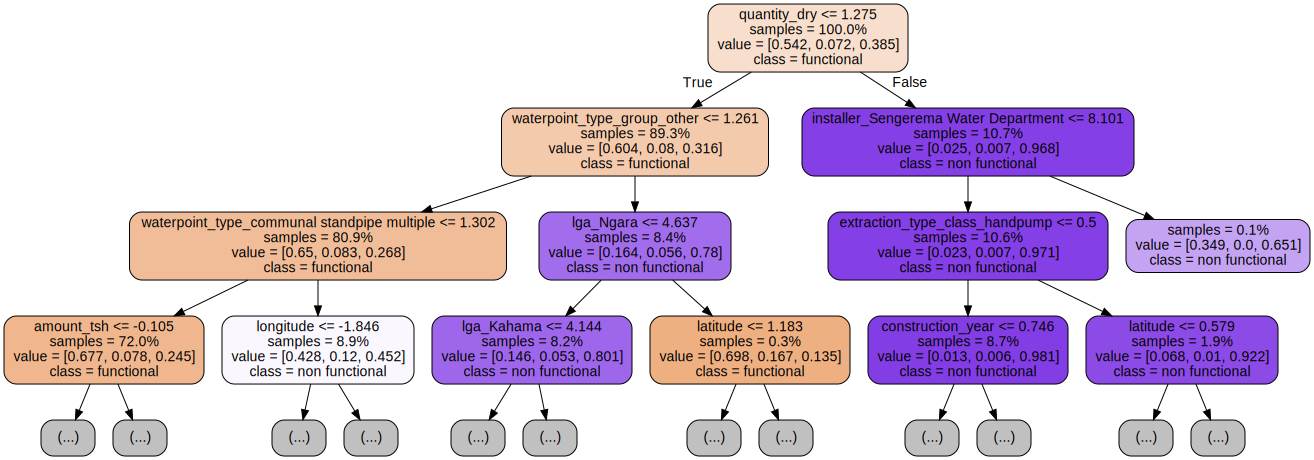

In [39]:
# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
from sklearn.tree import export_graphviz

model = pipeline4.named_steps['decisiontreeclassifier']
encoder = pipeline4.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

In [0]:
%matplotlib inline
import itertools
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns

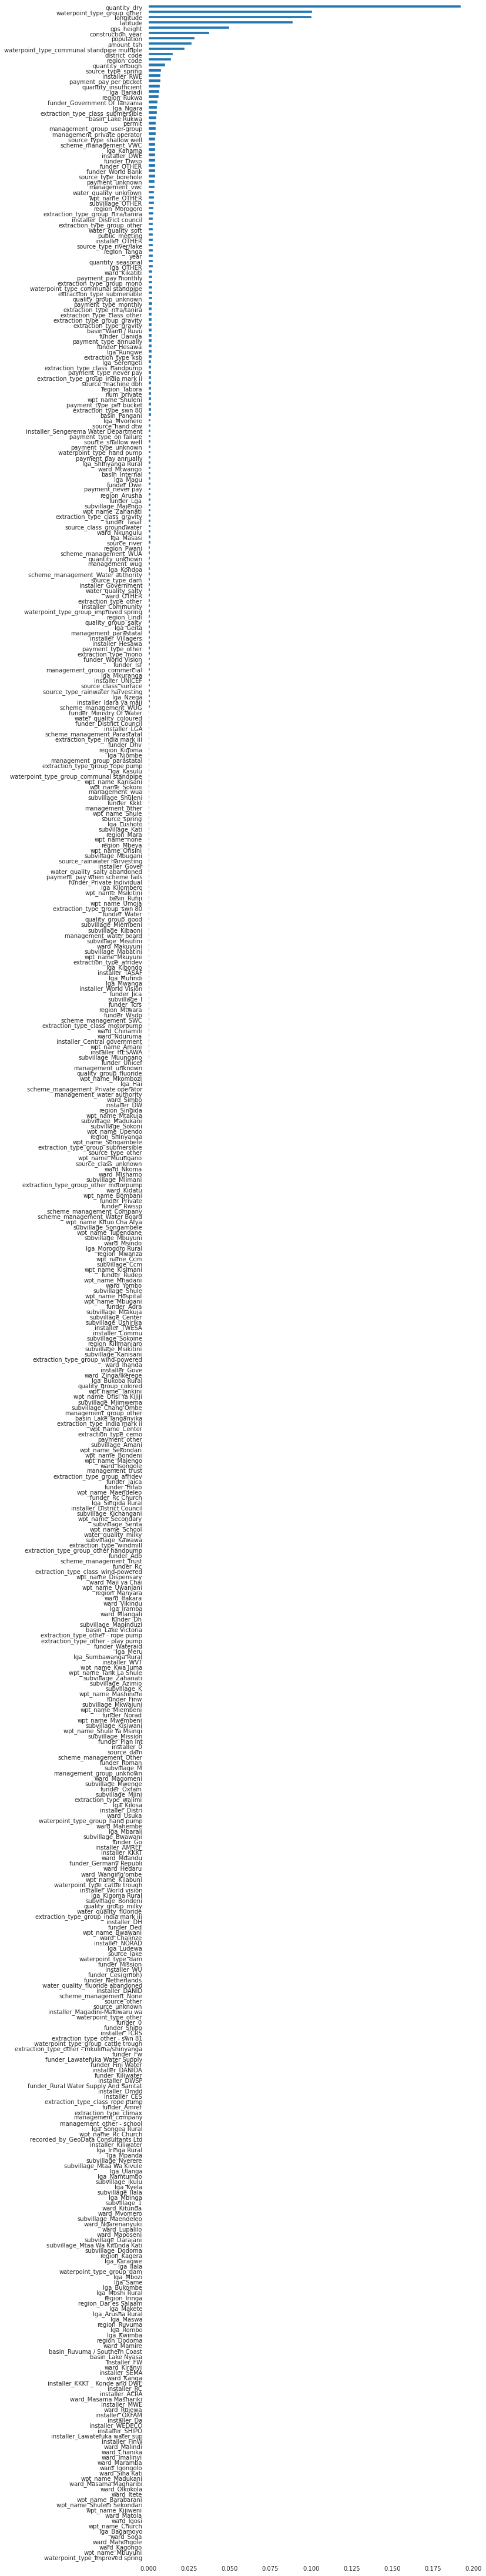

In [46]:
#DecisionTree Model feature importances

model = pipeline_dt.named_steps['decisiontreeclassifier']
encoder = pipeline_dt.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10, 80))
importances.sort_values().plot.barh();